In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 250
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 10
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon and a dragon, and I'm a dragon. I'm a dragon. I'm a dragon.

I've been in a dragon world for almost a decade. I've lived in a dragon world for about two and a half years. I've had dragon lovers and dragons in my life. I've had dragons and dragons.

I've been in a dragon world for about five years. I've lived in a dragon world for about two and a half years. I've had dragon lovers and dragons in my life. I've had dragons and dragons.

I've been in


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>black<msg>m "Anna walked over to a fenced enclosure of animals that reminded me of sheep. She crouched and squeezed herself through the bars, after which I lost sight of her."<|endoftext|><d><scn>black<msg>Lo "There are many things you can do, but it's very open-ended and you can live your life there however you want to."<|endoftext|><d><scn>bareblur<msg>m "Once again, he consumed his drink, though his swigs were noticeably slower than before. His resolve was also fading, though not as
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors


p><msg>c "Does that mean I win?"<|endoftext|><d><scn>beach<msg>Ad "Actually, that sounds pretty nice!"<|endoftext|><p><msg>c "I thought it was a joke. Of course, all of that changed once I came through the portal."<|endoftext|><p><msg>c "Fight Adine"<d><scn>beach<msg>m "Adine dodges my attack and comes rushing towards me"<|endoftext|><d><scn>black<msg>n "When I finally arrived, I was glad to fall into bed and sleep away the
 whole evening."<|endoftext|><p><msg>c "It's a shame. I bet your stunts would have been amazing to see."<|endoftext|><p><msg>c "Yeah."<|endoftext|><p><msg>c "I'm good, thanks."<|endoftext|><d><scn>park2<msg>Ry "Maybe you saw those pictures in my apartment."<|endoftext|><p><msg>c "It's my pleasure."<|endoftext|><d><scn>loremapt<msg>m "Lorem returned to his drawing, the silence only being interrupted by the strokes of his pen."<|endoftext|><d><scn>


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
267,1.880600
534,1.309700
801,1.067300
1068,1.301900
1335,1.173700
1602,1.285700
1869,1.374000
2136,1.350900
2403,4.734000
2670,2.779800


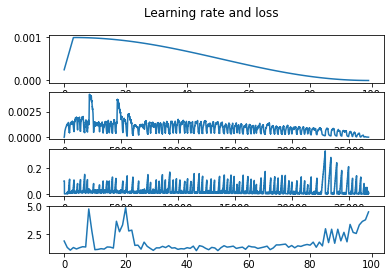

In [9]:
fig, axs = plt.subplots(4)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['mix_rate'])
axs[3].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 1.07 MiB/s, done.
Using framework PyTorch: 1.10.1+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyTor

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm
PyTorch: In my dreams, I'm a dragon in a glass tower. I can hear a dragon calling to me. I've seen dragon wings in my dream. I've seen dragons that look like dragon wings. I've seen dragons that look like dragons. I've seen dragons that look like dragons. I've seen dragons that look like dragons. I've seen dragons that look like dragons. I've seen dragons that look like dragons. I've seen dragons that look like dragons. I've seen dragons that look like dragons. I've seen dragons that look like dragons. I've seen dragons that look like dragons. I've seen dragons that look
----------------------------------

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [15]:
test_regular_sampler()

In my dreams, I'm a dragon-hunter. I'm a dragon-hunter-for-hire, and I'm the dragon-hunter for the Dragon Clan. I'm a dragon-hunter-and-dragon-hunter-for-hire, and I'm the dragon-hunter for the Dragon Clan. And, I'm the dragon-hunter for the Dragon Clan. So, I'm a dragon-hunter.

I've always been a dragon-hunter. I've always been a dragon-hunter-for-hire.

I've always been a dragon-hunter-for-hire. I've always been


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "How are you?"<p><msg>c "How are you?"<d><scn>park2<msg>Ry "How are you?"<p><msg>c "How are you?"<d><scn>park2<msg>Ry "How are you?"<p><msg>c "How are you?"<d><scn>park2


Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "Very nice."<p><msg>


Prompt: Oh my god, Adine. What is this?
Reply: c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine.


Prompt: What will we do here?
Reply: c "I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure. I'm not sure


Test ONNX...


# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-" * 10)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: Park2<msg>Ry "How are you?"<p><msg>c "What are you doing here?"<d><scn>Park2<msg>Ry "I am just here."<p><msg>c "How are you?"<d><scn>Park2<msg>Ry "How are you?"<p><msg>c "How are you?"<d><scn

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I don't know."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "I don't know."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "I don't know

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: Adine: I'm sorry, but the guy said it was a joke.<d><scn>Adine: No, but it's true.</scn></d></msg></scn></p>

<p><msg>m "I know this is stupid, but I think it is stupid. But you have to be aware that I'm not the only person in the world who thinks that

[Test 1] -> Prompt: What will we do here?
Reply: c "You're on a journey to the future, right?" "Yes, I am.<p><msg>s "I'll be on a journey to the future"<d><scn>s "I'll be on a journey to the future"<d><scn

# RP test
Testing out the injected roleplay actions

In [18]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'[Pytorch] {rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print(f'[ONNX] {rp} -> {onnx_model_manager.say("", rp, do_sample = True)}')
    print("-" * 10)

[Pytorch] Visit Lorem -> &nbsp;</scn></msg></p>
<p><msg>c "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesentur dolor euismod, et dolore magna ut quid qui ante. Quisquam quid suscipit, et port, portum dolor, magna ut quid quis, sed diam, sed dolor. Ut iure et, dolore non erat dol
[ONNX] Visit Lorem -> c "</scn></d>
<p><msg>d</scn></p><p><scn>d"</scn></p><p><scn>d"</d></pc>
</div><|endoftext|>
----------
[Pytorch] Meet with Lorem -> <d><d><scn></scn></scn></d></msg></p>
<p><scn><d><scn></scn></d></scn></p>
<p><scn><d><scn></scn></d></scn></p>
<p><scn><d><scn></scn></d></scn></p>
<p><sc
[ONNX] Meet with Lorem -> c "Lorie"<d><scn>c "C"<scn>c "Lorie"<d><scn>c "C"<scn>c "C"<scn>c "Lorie"<d><scn>c "Lorie"<d><scn>c "C"<scn>c "C"<scn>c "Lorie"<d><scn>c "Lorie"<d><scn>c "C"<scn>c "Lorie"<d><scn>c "C
----------
[Pytorch] Visit Adine -> /s/d/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/e/
[ONNX] Visit Adine -> c "Adine"<d><